# Simpsons character classifier

#### Goal: Classify ‘The Simpsons’ characters screenshots using a convolutional neural net

In [1]:
%matplotlib inline

# Imports
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import History

import pandas as pd
from matplotlib import pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Preprocess images

In [2]:
batch_size = 16
img_dim = 100 # to resize images to img_dim x img_dim

# Augment training image dataset with slightly transformed images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1)

test_datagen = ImageDataGenerator(
    rescale=1./255)

train_gen = train_datagen.flow_from_directory('simpsons_training',
                                              target_size=(img_dim, img_dim),
                                              shuffle = True,
                                              batch_size = batch_size)

# Testing images are only available for 20 of the characters, and not for all characters in the training dataset
test_gen = test_datagen.flow_from_directory('simpsons_testing', 
                                            target_size=(img_dim, img_dim),
                                            shuffle = True,
                                            batch_size = batch_size)

Found 20933 images belonging to 47 classes.
Found 990 images belonging to 47 classes.


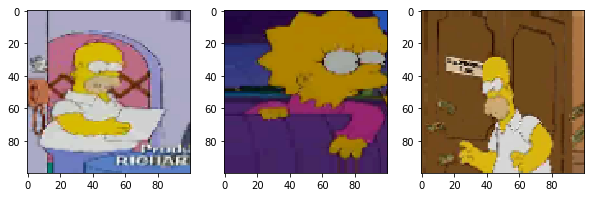

In [3]:
# Preview some augmented training images
plt.figure(figsize=(10,3))
x,y = train_gen.next()
for i in range(0,3):
    image = x[i]
    plt.subplot(1,3,i+1)
    plt.imshow(image)

In [4]:
# Conditional code to save more augmented images to directory
save_aug_imgs = False;
if save_aug_imgs == True:
    train_gen = train_datagen.flow_from_directory('simpsons_training',
                                                  target_size=(img_dim, img_dim),
                                                  shuffle = False,
                                                  batch_size = batch_size,                                             
                                                  save_to_dir='augmented',
                                                  save_prefix='augmented')
    i = 0
    for batch in train_gen:
        i += 1
        if i > 10: # save this many * batch size images
            break  # otherwise the generator would loop indefinitely

### Build convolutional neural network layers

In [5]:
# 5 convolutional layers, 2 dense layers, and an output layer
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_dim, img_dim, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dense(47))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Train the neural network using augmented training images 

In [6]:
history = History()

# Train new model, else load trained model
train_new_model = False;
if train_new_model == True:
    model.fit_generator(train_gen,
                        steps_per_epoch = 20000//batch_size,
                        epochs = 50,
                        validation_data = test_gen,
                        validation_steps = 1500//batch_size,
                        callbacks=[history])
    # Save the model and scores during training epochs
    model.save('CNN_5c3d.h5')
    history_df = pd.DataFrame(history.history)
    history_df.to_csv("history.csv")
else:
    model = keras.models.load_model('CNN_5c3d.h5')
    history_df = pd.read_csv('history.csv')

Text(0.5,0,'Epoch')

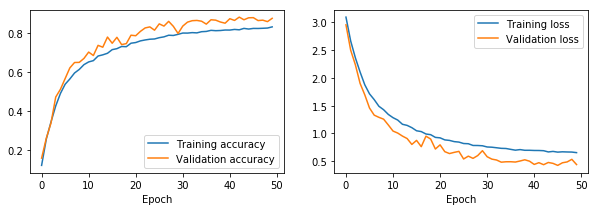

In [7]:
plt.figure(figsize=(10,3))
# Training history
ax = plt.subplot(1,2,1)
history_df['acc'].plot()
history_df['val_acc'].plot()
ax.legend(['Training accuracy','Validation accuracy'])
ax.set_xlabel('Epoch')
ax = plt.subplot(1,2,2)
history_df['loss'].plot()
history_df['val_loss'].plot()
ax.legend(['Training loss','Validation loss']);
ax.set_xlabel('Epoch')

After 50 epochs (about 2 hours of training on a 940MX GPU), the model reached a validation accuracy rate of 87%.

I excluded dropout in the dense layers because early versions of the model that did include dropout had low training accuracy. The learning curve does not suggest overfitting and therefore a need for dropout. In fact, accuracy is slightly higher for validation than for training. This could be due to the augmentations that make the training set more challenging for the model.

### Visualize character predictions

In [8]:
# Create a dictionary to map output indices to character names
label_inv_dict = train_gen.class_indices
label_dict = {v: k for k, v in label_inv_dict.items()}

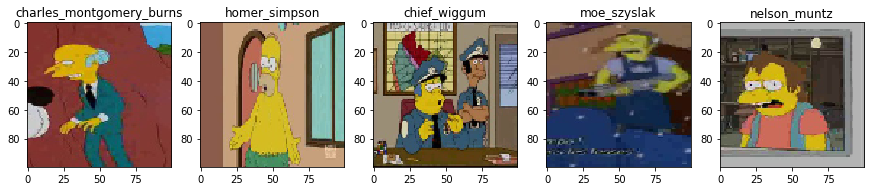

In [9]:
# View test images and predicted labels
plt.figure(figsize=(15,5))
x,y = test_gen.next()
for i in range(0,5):
    image = x[i]
    y_prob = model.predict(x) 
    y_class = y_prob[i].argmax(axis=-1)
    y_label = label_dict[y_class]
    ax = plt.subplot(1,5,i+1)
    ax.set_title(y_label)
    plt.imshow(image)